In [1]:
import pandas as pd
import torch

In [2]:
# Loss function: MSE
def loss_fn(target: torch.Tensor, network_output: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(target - network_output))

In [8]:
import sys
sys.path.append('..')

from utilities import linear_net

In [11]:
input_indices = [3, 5, 10, 15]
verification_data_sizes = [30, 90, 270, 1000, 10000]
for N in input_indices:
    # Load data
    input_data = pd.read_csv(f"input_exp_linspace_{N}.csv")
    x = torch.tensor(input_data['x'], dtype = torch.float32)[:, None]
    target = torch.tensor(input_data['y'], dtype = torch.float32)[:, None]

    for use_sigmoid in [True, False]:
        # Get net
        NN = linear_net.Net(10, torch.nn.Sigmoid()) if use_sigmoid \
            else linear_net.Net(10, torch.nn.ReLU(0.2))

        # Get optimizer
        optimizer = torch.optim.Adam(NN.parameters(), lr=1e-1)

        # Training phase
        it_counter = 0
        while True:
            optimizer.zero_grad()
            loss = loss_fn(target, NN(x))
            if loss < 1e-4 or it_counter > 5000:
                break
            else:
                loss.backward()
                optimizer.step()
                it_counter = it_counter + 1

        # Verification phase
        loss_results = [0] * len(verification_data_sizes)
        i = 0

        for M in verification_data_sizes:    
            verification_data = pd.read_csv(f'verification_exp_linspace_{M}.csv')
            x = torch.tensor(verification_data['x'], dtype = torch.float32)[:, None]
            target = torch.tensor(verification_data['y'], dtype = torch.float32)[:, None]

            loss_results[i] = torch.sqrt(torch.sum(torch.square(target - NN(x))) / M).detach().numpy()
            i = i + 1

        filename = f'training_performance_exp_{N}_sigmoid.csv' if use_sigmoid \
                        else f'training_performance_exp_{N}_relu.csv'
        results = pd.DataFrame(data = {"N": verification_data_sizes, "2_norm": loss_results})
        results.to_csv(filename, index = False)

# Show results

In [31]:
performances_sigmoid = []
performances_relu = []
for N in input_indices:
    results_sigmoid = list(pd.read_csv(f'training_performance_exp_{N}_sigmoid.csv')['2_norm'])
    results_relu = list(pd.read_csv(f'training_performance_exp_{N}_relu.csv')['2_norm'])
    performances_sigmoid += results_sigmoid
    performances_relu += results_relu

<Axes: title={'center': 'ReLU 2-norm'}>

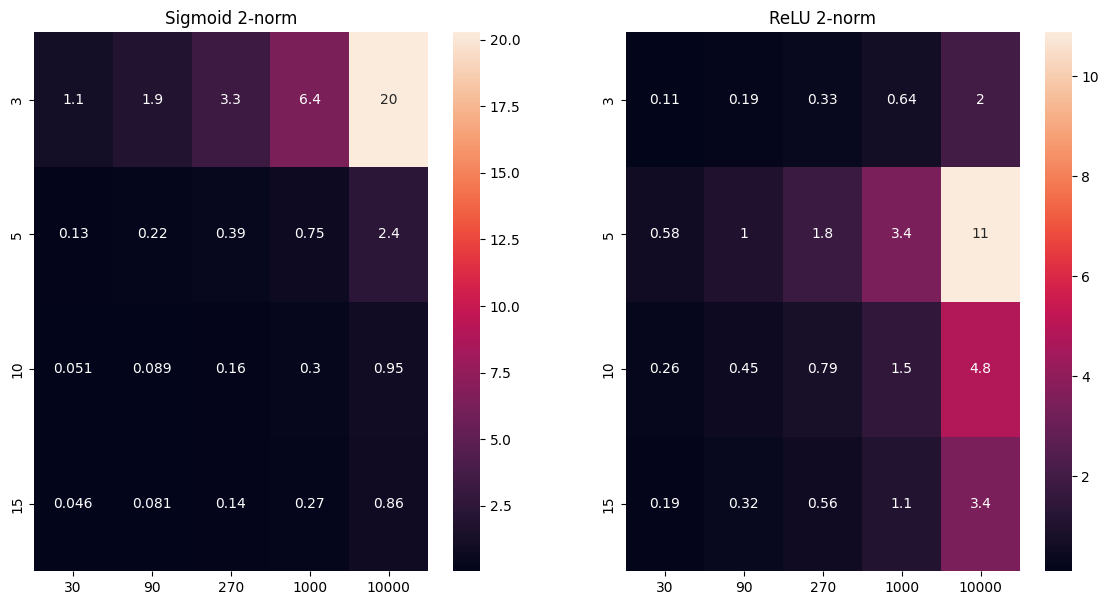

In [43]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np

results_sigmoid = np.array(performances_sigmoid)
results_relu = np.array(performances_relu)

fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
ax1.set_title('Sigmoid 2-norm')
ax2.set_title('ReLU 2-norm')
# x axis: input_indices
# y axis: verification_data_sizes

input_data_sigmoid = results_sigmoid.reshape(len(input_indices), len(verification_data_sizes))
input_data_relu = results_relu.reshape(len(input_indices), len(verification_data_sizes))
seaborn.heatmap(data = input_data_sigmoid, annot = input_data_sigmoid, 
                ax = ax1, xticklabels = verification_data_sizes, yticklabels = input_indices)
seaborn.heatmap(data = input_data_relu, annot = input_data_relu,
                ax = ax2, xticklabels = verification_data_sizes, yticklabels = input_indices)